In [85]:
import sys
import numpy as np
import matplotlib.pyplot as plt
sys.path.append('/mnt/d/ariel2/code/core/')
import kaggle_support as kgs
train_data = kgs.load_all_train_data()
data = np.stack([d.spectrum for d in train_data])
wavelengths = kgs.wavelengths[1:]
data = data[:,1:].T
data.shape

(282, 1099)

Text(0, 0.5, 'Transit depth')

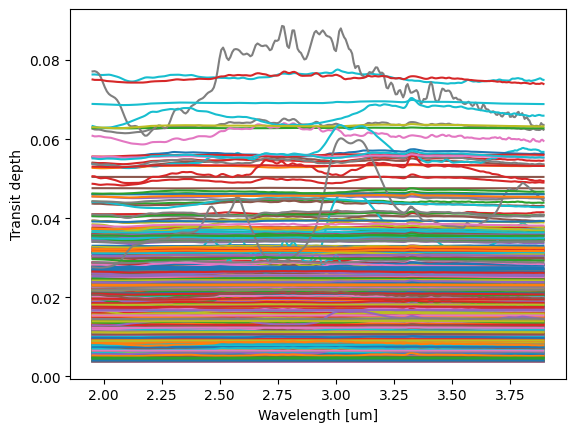

In [86]:
plt.figure()
plt.plot(wavelengths, data);
plt.xlabel('Wavelength [um]')
plt.ylabel('Transit depth')

Text(0, 0.5, 'Transit depth (mean removed)')

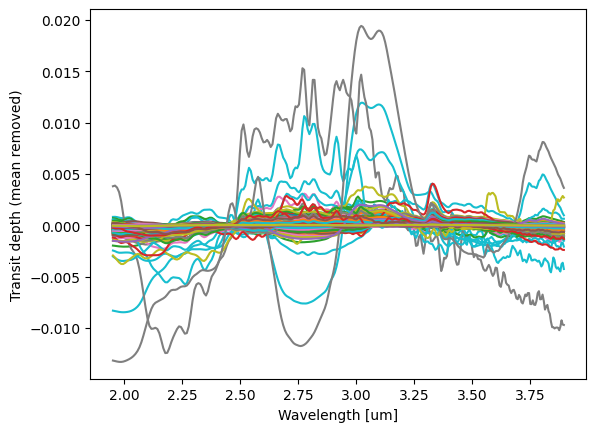

In [3]:
plt.figure()
plt.plot(wavelengths, data-np.mean(data,0));
plt.xlabel('Wavelength [um]')
plt.ylabel('Transit depth (mean removed)')

0.7534121929026387


Text(0, 0.5, 'Transit depth (mean removed, normalized)')

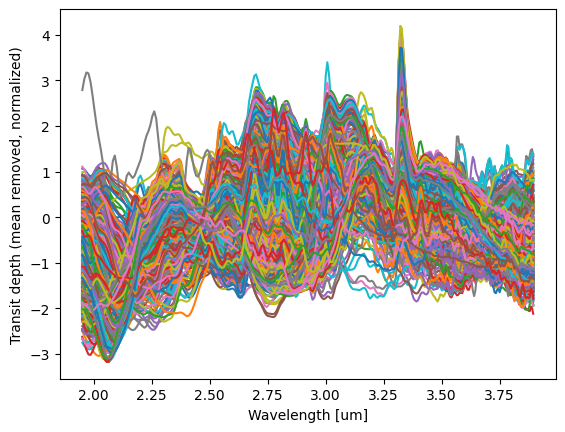

In [9]:
high_std = np.std(data,0)>2e-5
print(np.sum(high_std)/len(high_std))
this_data = data[:,high_std]
data_norm = (this_data-np.mean(this_data,0))/np.std(this_data,0)
plt.figure()
plt.plot(wavelengths, data_norm);
plt.xlabel('Wavelength [um]')
plt.ylabel('Transit depth (mean removed, normalized)')

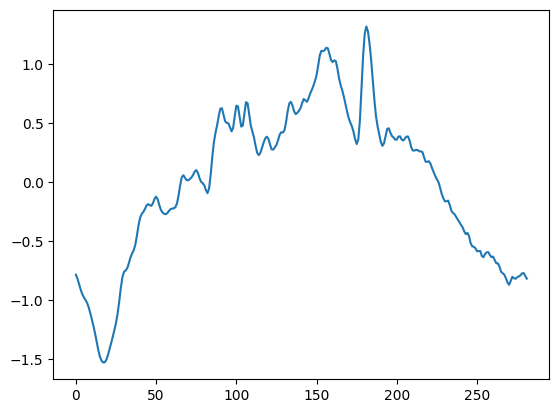

In [10]:
plt.figure()
plt.plot(np.mean(data_norm,1))

Text(0, 0.5, 'Std of transit depth')

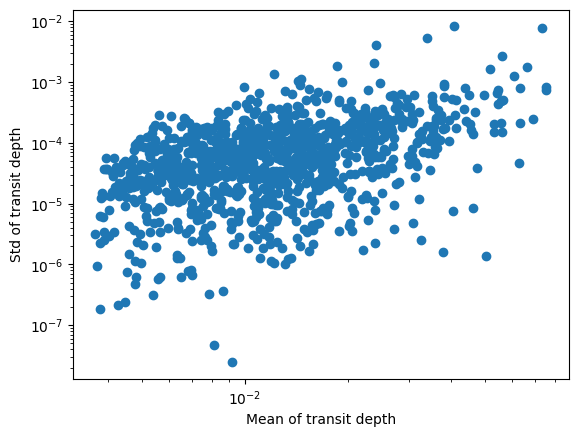

In [7]:
plt.figure()
plt.scatter(np.mean(data,0), np.std(data,0))
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Mean of transit depth')
plt.ylabel('Std of transit depth')

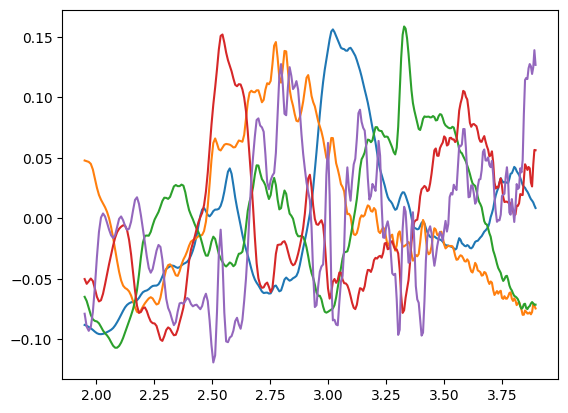

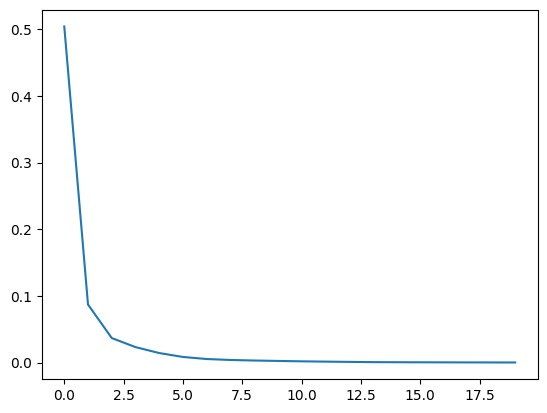

In [8]:
from sklearn.decomposition import PCA
import numpy as np

N=1

pca = PCA()
pca.fit((data-np.mean(data,0)).T)
components = pca.components_          # Principal directions (eigenvectors)
explained_variance = 1-np.cumsum(pca.explained_variance_ratio_)  # Variance explained by each PC

plt.figure()
plt.plot(wavelengths,components[:5,:].T);
plt.figure()
plt.plot(explained_variance[:20])

In [66]:
import numpy as np
from scipy.spatial.distance import pdist, squareform
from scipy.interpolate import UnivariateSpline
from numpy.linalg import eigh
import scipy

def empirical_cov(Y):
    # Y: (N,M), rows = sample paths, cols = points
    Yc = Y - Y.mean(axis=0, keepdims=True)
    return (Yc.T @ Yc) / (Y.shape[0] - 1)

def bin_by_distance(x, K, nbins=50, min_per_bin=20):
    x = np.asarray(x).ravel()
    D = squareform(pdist(x[:,None], 'euclidean'))  # (M,M)
    r = D[np.triu_indices_from(D)]
    v = K[np.triu_indices_from(K)]
    # bin edges from 0 to max distance
    edges = np.linspace(0, r.max() + 1e-12, nbins+1)
    centers, means = [], []
    for a,b in zip(edges[:-1], edges[1:]):
        mask = (r >= a) & (r < b)
        if mask.sum() >= min_per_bin:
            centers.append(0.5*(a+b))
            means.append(v[mask].mean())
    return np.array(centers), np.array(means)

def smooth_kernel(r, k_r, s=None):
    # s: smoothing factor (None lets spline choose ~ good default)
    # Enforce evenness & k'(0)=0 by mirroring
    r_full = np.concatenate([-r[::-1], r])
    k_full = np.concatenate([k_r[::-1], k_r])
    #spl = UnivariateSpline(r_full, k_full, s=s)
    spl = scipy.interpolate.interp1d(r_full, k_full, fill_value='extrapolate')
    plt.figure()
    plt.plot(r_full,k_full)
    plt.title('Input to spline')
    def kfun(h):
        h = np.abs(np.asarray(h))
        return spl(h)
    return kfun

def nearest_psd(A, eps=1e-12):
    # Higham-like eigenvalue clipping
    w, V = eigh((A + A.T)/2)
    w = np.clip(w, eps, None)
    return (V * w) @ V.T

# Example parametric kernels
def k_rbf(r, amp, ell): return amp**2 * np.exp(-0.5*(r/ell)**2)
def k_matern32(r, amp, ell): 
    z = np.sqrt(3)*r/ell
    return amp**2 * (1+z)*np.exp(-z)

def fit_parametric_from_cov(x, K_emp, family='matern32', nugget=True):
    from scipy.optimize import minimize

    D = squareform(pdist(x[:,None], 'euclidean'))
    def K_theta(theta):
        amp = np.exp(theta[0]); ell = np.exp(theta[1])
        if family == 'rbf':
            K = k_rbf(D, amp, ell)
        else:
            K = k_matern32(D, amp, ell)
        if nugget:
            sn2 = np.exp(theta[2])
            K = K + sn2*np.eye(len(x))
        return K

    # init guesses from data scale
    amp0 = np.sqrt(np.median(np.diag(K_emp)))
    ell0 = (x.max()-x.min())/5
    th0 = [np.log(max(amp0,1e-6)), np.log(max(ell0,1e-6))]
    if nugget:
        sn20 = max(1e-6, 0.01*np.median(np.diag(K_emp)))
        th0.append(np.log(sn20))

    def obj(theta):
        Kt = K_theta(theta)
        R = K_emp - Kt
        return np.sum(R*R)  # Frobenius norm squared

    res = minimize(obj, np.array(th0), method='L-BFGS-B')
    return res

def estimate_kernel(x, Y, nbins=50, min_per_bin=20, smooth_s=None, enforce_psd=True):
    # Empirical covariance
    K_emp = empirical_cov(Y)
    plt.figure()
    plt.imshow(K_emp)
    plt.colorbar()

    # Nonparametric kernel estimate (bin + smooth)
    r, k_r = bin_by_distance(x, K_emp, nbins=nbins, min_per_bin=min_per_bin)
    plt.figure()
    plt.plot(r,k_r)
    kfun = smooth_kernel(r, k_r, s=smooth_s)
    plt.figure()
    plt.plot(r,kfun(r))

    # Build covariance from kfun on grid
    D = squareform(pdist(np.asarray(x)[:,None], 'euclidean'))
    K_np = kfun(D)

    if enforce_psd:
        K_np = nearest_psd(K_np)

    return K_np, kfun, K_emp

Fitted params (log): [-0.77670003 -2.55436148 -6.4557749 ]


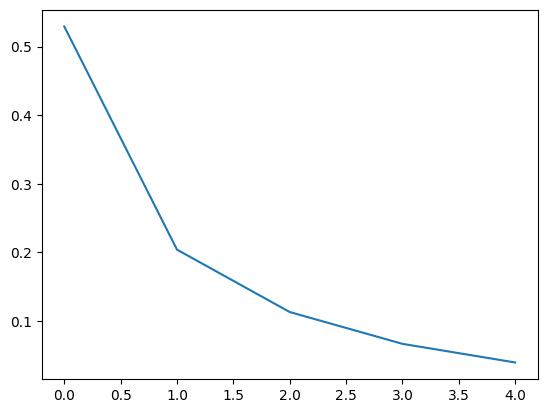

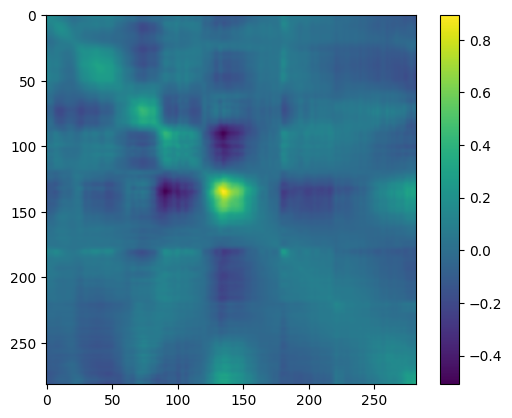

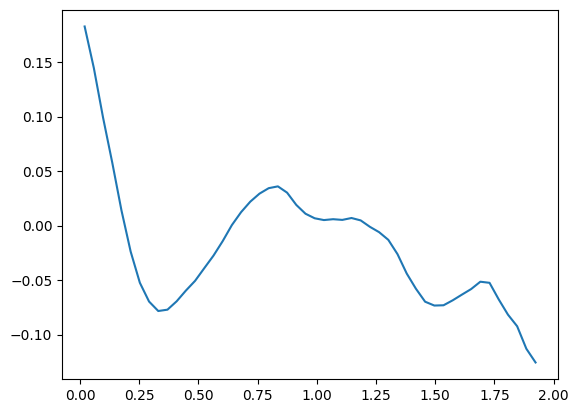

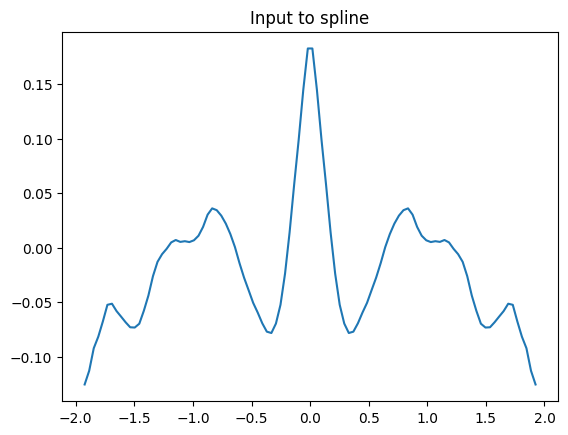

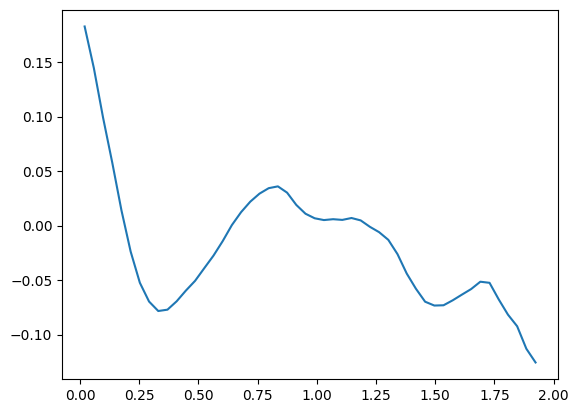

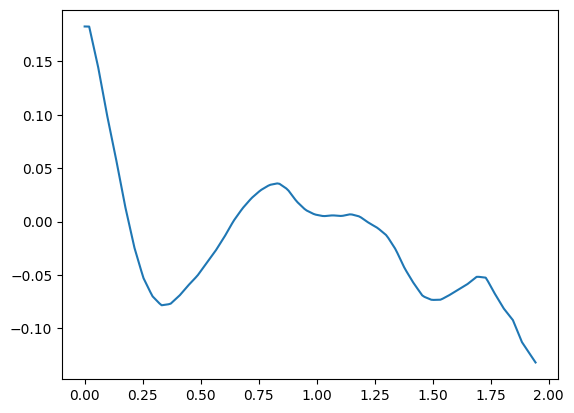

In [90]:

x=kgs.wavelengths[1:]
dat = data_norm
Y=(dat-np.mean(dat,0)).T
Y=Y-np.mean(Y,1)[:,None]

pca = PCA(n_components=5)
pca.fit(Y.T)
components = pca.components_          # Principal directions (eigenvectors)
explained_variance = 1-np.cumsum(pca.explained_variance_ratio_)  # Variance explained by each PC

plt.figure()
plt.plot(explained_variance)

ii=2
scores = pca.transform(Y.T)[:, :ii]             # (n_samples, ii)
recon = scores @ pca.components_[:ii, :]      # (n_samples, 64)
recon += pca.mean_    

Y = Y-recon.T

# x: shape (M,), Y: shape (N,M)
K_np, kfun, K_emp = estimate_kernel(x, Y)

# Evaluate kernel at any lag r>=0:
r_test = np.linspace(0, (x.max()-x.min()), 200)
k_vals = kfun(r_test)

plt.figure()
plt.plot(r_test,k_vals)

# # (Optional) fit a parametric kernel to the empirical covariance:
res = fit_parametric_from_cov(x, K_emp, family='matern32', nugget=True)
print("Fitted params (log):", res.x)

In [40]:
data_norm.shape

(282, 828)

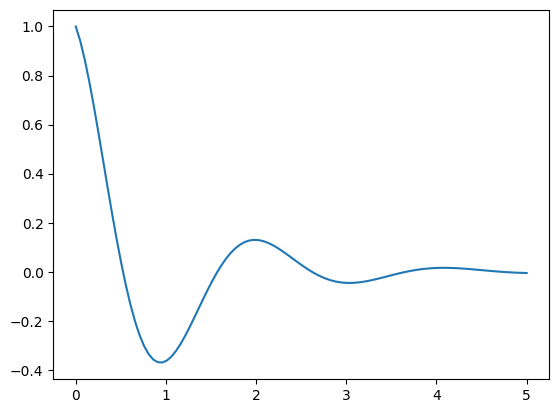

In [80]:
x=np.linspace(0,5,100)
plt.plot(x,np.exp(-np.abs(x))*np.cos(np.abs(x*3)))

In [81]:
transit_prior_info = kgs.dill_load(kgs.code_dir + 'transit_depth_gp_with_pca.pickle')

In [82]:
transit_prior_info

{'lengths': [array([2], dtype=int32),
  array([1], dtype=int32),
  array([0.5]),
  array([0.25]),
  array([0.125]),
  array([0.0625]),
  array([0.03125]),
  array([0.015625]),
  array([0.0078125])],
 'sigmas_per_npca': [array([3.23431819e-07, 4.66728545e-07, 1.42783102e-06, 8.56488354e-05,
         3.66232404e-08, 6.37950741e-08, 2.59998417e-05, 8.09542623e-06,
         3.63101550e-10, 8.56488354e-08]),
  array([1.00999019e-06, 1.43740462e-06, 3.72180722e-06, 4.40671879e-05,
         1.24511134e-05, 9.75320590e-06, 1.19744465e-05, 6.69833447e-06,
         7.12417899e-09, 4.40671879e-08]),
  array([6.81035782e-08, 8.28529703e-08, 1.18121588e-07, 2.29047856e-07,
         1.71226264e-05, 4.15770649e-06, 7.15302601e-06, 4.98994345e-06,
         1.11822441e-12, 1.71226264e-08]),
  array([8.25793567e-08, 9.27617471e-08, 1.27611942e-07, 5.53882296e-07,
         1.09955774e-05, 8.39505595e-08, 6.33465845e-06, 3.57291305e-06,
         5.62757959e-09, 1.09955774e-08]),
  array([8.52350459e-08, 9